# Import library

In [1]:
import os
import torch
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
from torchvision.transforms import ToPILImage
from torchvision.models import ResNet50_Weights
import torchvision.transforms as transforms
from torchmetrics.detection.mean_ap import MeanAveragePrecision
from torchvision.models.detection.faster_rcnn import FasterRCNN, TwoMLPHead, FastRCNNPredictor
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone
from torchvision.ops.poolers import MultiScaleRoIAlign
from torchvision.models.detection.rpn import AnchorGenerator, RegionProposalNetwork
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image, ImageDraw, ImageFont
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from torchmetrics.detection.mean_ap import MeanAveragePrecision
import pandas as pd
from collections import defaultdict
from torchvision.models.detection import fasterrcnn_resnet50_fpn_v2
from torchvision.models.detection import FasterRCNN_ResNet50_FPN_V2_Weights

# Prepare data

**Tất cả label và id tương ứng**

In [2]:
all_labels = {0: 'Apple', 1: 'Banana', 2: 'Grapes', 3: 'Orange', 4: 'Pineapple', 5: 'Watermelon'}

**Đường dẫn tới dataset**

In [3]:
dataset_path = '/kaggle/input/k-67-object-detection/Dataset'

**Tạo class để lưu dataset. Ở đây label + 1 do khi dùng FasterRCNN label 0 sẽ mặc định là background, còn các class còn lại sẽ từ 1-6**

In [4]:
class ObjectDetectionDataset(Dataset):
    def __init__(self, root_dir, mode='train', transform=None):
        self.root_dir = root_dir
        self.mode = mode
        self.transform = transform
        
        if mode == 'train':
            self.image_dir = os.path.join(root_dir, 'Train', 'images')
            self.annotation_dir = os.path.join(root_dir, 'Train', 'labels')
            self.images_names = [f for f in os.listdir(self.image_dir) if f.endswith('.jpg')]
        elif mode == 'test':
            self.image_dir = os.path.join(root_dir, 'Test', 'images')
            self.images_names = [f for f in os.listdir(self.image_dir) if f.endswith('.jpg')]
        else:
            raise ValueError("Mode must be 'train' or 'test'")

    def __len__(self):
        return len(self.images_names)

    def __getitem__(self, idx):
        img_name = self.images_names[idx]
        img_path = os.path.join(self.image_dir, img_name)
        
        image = Image.open(img_path).convert("RGB")
        
        if self.mode == 'train':
            annotation_path = os.path.join(self.annotation_dir, img_name.replace('.jpg', '.txt'))
            boxes, labels = self._parse_annotation(annotation_path)
            
            target = {'boxes': boxes, 'labels': labels}
            
            if self.transform:
                image = self.transform(image)
            
            return image, target
        
        elif self.mode == 'test':
            if self.transform:
                image = self.transform(image)
            return image

    def _parse_annotation(self, annotation_path):
        boxes = []
        labels = []
        
        with open(annotation_path, 'r') as file:
            lines = file.readlines()
            for line in lines:
                parts = line.strip().split()
                label = int(parts[0])  
                x_min = float(parts[1])  
                y_min = float(parts[2])  
                x_max = float(parts[3])  
                y_max = float(parts[4])  
                boxes.append([x_min, y_min, x_max, y_max])
                labels.append(label)
        
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        
        return boxes, labels + 1

    def draw_boxes(self, image, boxes, labels, all_labels, fontsize=25):
        copy = image.copy()
        draw = ImageDraw.Draw(copy)
        #font = ImageFont.truetype("DejaVuSans-Bold.ttf", size=fontsize)
        font = ImageFont.load_default(size=fontsize)

        
        for i, box in enumerate(boxes):
            x_min, y_min, x_max, y_max = box
            label = labels[i]
            
            draw.rectangle([x_min, y_min, x_max, y_max], outline="green", width=8)
            
            draw.text((x_min, y_min), str(all_labels[label.item() - 1]), fill="blue", font=font)
        
        return copy

**Chuyển ảnh thành tensor và cho vào class dataset**

In [5]:
transform_train = transforms.Compose([
    transforms.ToTensor()
])

transform_test = transforms.Compose([
    transforms.ToTensor()
])

In [6]:
all_trainset = ObjectDetectionDataset(dataset_path, 'train', transform=transform_train)
#train_size = int(0.8 * len(all_trainset))
#val_size = len(all_trainset) - train_size
#trainset, valset = random_split(all_trainset, [train_size, val_size])
testset = ObjectDetectionDataset(dataset_path, 'test', transform=transform_test)

**Vẽ ảnh và box**

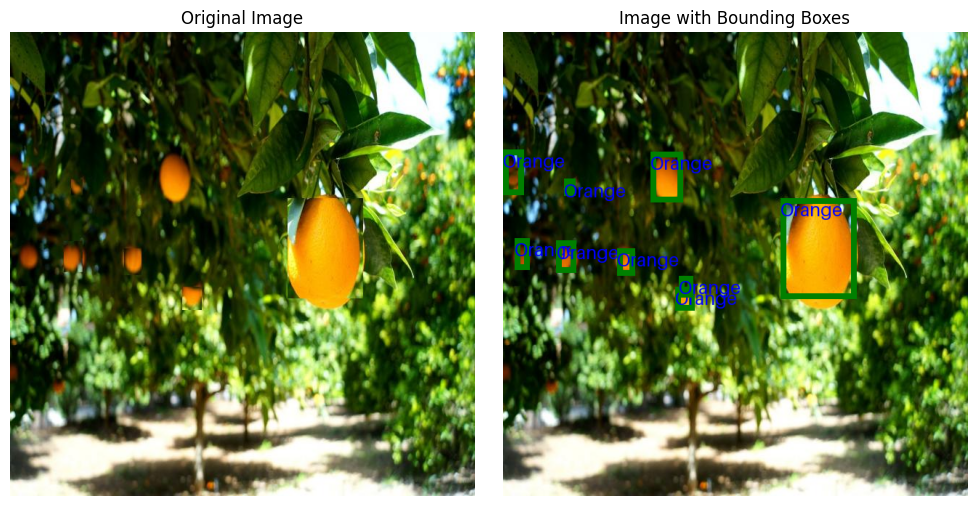

In [7]:
#image, target = trainset[0]
image, target = all_trainset[0]
boxes = target['boxes']
labels = target['labels']

to_pil = ToPILImage()
img = to_pil(image)

image_with_boxes = all_trainset.draw_boxes(img, boxes, labels, all_labels)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(img)
axes[0].set_title('Original Image')
axes[0].axis('off') 

axes[1].imshow(image_with_boxes)
axes[1].set_title('Image with Bounding Boxes')
axes[1].axis('off')

plt.tight_layout()
plt.show()

**Số lượng ảnh và kích thước ảnh**

In [8]:
#print(f'Train: {len(trainset)}')
#print(f'Valid: {len(valset)}')
print(f'Train: {len(all_trainset)}')
print(f'Test: {len(testset)}')
print(f'Image shape: {image.shape}')

Train: 7631
Test: 848
Image shape: torch.Size([3, 640, 640])


**Cho dữ liệu vào dataloader**

In [9]:
def collate_fn(batch):
    images = [item[0] for item in batch]  
    targets = [item[1] for item in batch]  
    return images, targets

def collate_fn_test(batch):
    images = [item for item in batch]  
    return torch.stack(images, dim=0)

In [9]:
train_loader = DataLoader(all_trainset, batch_size=64, shuffle=True, num_workers=4, collate_fn=collate_fn, pin_memory=True)
#val_loader = DataLoader(valset, batch_size=64, shuffle=False, num_workers=4, collate_fn=collate_fn, pin_memory=True)
test_loader = DataLoader(testset, batch_size=64, shuffle=False, num_workers=4, collate_fn=collate_fn_test, pin_memory=True)

# Model

**Ở đây em sẽ custom lại một mạng FasterRCNN với backbone Resnet50 đã được pretrained trên tập ImageNet và huấn luyện lại từ đầu trên tập dữ liệu trong competition. Em cũng sử dụng FasterRCNN đã được pretrained trên tập CoCo và finetune trên tập dữ liệu trong competition**

## Custom FasterRCNN (mAP in 40% test Leaderboard: huynt119 - 0.5205)

**Ở đây sử dụng backbone Resnet50 xây dựng theo cấu trúc FPN. Backbone đã được pretrained trên tập ImageNet. Ở đây em chỉ dùng 3 layer đầu ra (returned_layers=[1, 2]) và đóng băng toàn bộ mạng backbone (trainable_layers=0)**

In [10]:
backbone = resnet_fpn_backbone(backbone_name='resnet50', weights=ResNet50_Weights.DEFAULT, returned_layers=[1, 2], trainable_layers=0)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 189MB/s] 


**Kiểm tra đầu ra của backbone. Backbone trả về 3 feature maps với số chiều là 256**

In [11]:
x = torch.rand(1,3,640,640)
outs = backbone(x)
for key, value in outs.items():
    print(key, value.shape)

0 torch.Size([1, 256, 160, 160])
1 torch.Size([1, 256, 80, 80])
pool torch.Size([1, 256, 40, 40])


**Định nghĩa anchor generator. Ở đây sử dụng anchor với 3 kích thước 64, 128, 256 cho 3 tầng feature maps trích xuất được ở phần backbone. Sử dụng tỉ lệ 0.5, 1.0, 2.0 cho anchor của mỗi tầng. Tổng cộng mỗi điểm trên feature maps có 3x3 = 9 anchors**

In [12]:
anchor_sizes = ((64,), (128,), (256,))  
aspect_ratios = ((0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0))         

anchor_generator = AnchorGenerator(sizes=anchor_sizes, aspect_ratios=aspect_ratios)

**Custom lại RPNHead. Trả về dự đoán lớp và box. Cải tiến lớp Conv so với code trong torchvision(code gốc lớp Conv với số chiều đầu vào và đầu ra bằng nhau và cố định). Với in_channels là 256, em chọn hidden_channels là 512, tuy nhiên do thời gian tính toán quá lâu nên hidden_channels chỉnh lại là 256**

In [13]:
class RPNHead(nn.Module):
    def __init__(self, in_channels, hidden_channels, num_anchors):
        super(RPNHead, self).__init__()
        self.conv = nn.Conv2d(in_channels, hidden_channels, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()

        self.cls_logits = nn.Conv2d(hidden_channels, num_anchors * 1, kernel_size=1)

        self.bbox_pred = nn.Conv2d(hidden_channels, num_anchors * 4, kernel_size=1)

    def forward(self, x):
        logits = []
        bbox_reg = []
        for feature in x:
            t = self.relu(self.conv(feature))
            logits.append(self.cls_logits(t))
            bbox_reg.append(self.bbox_pred(t))
        return logits, bbox_reg
        

num_anchors = len(anchor_sizes[0]) * len(aspect_ratios[0])
hidden_channels = 256
rpn_head = RPNHead(backbone.out_channels, hidden_channels, num_anchors)

**Định nghĩa RoI Align. Dùng MultiScaleRoIAlign để kết hợp các Region of Interest (RoI) từ 3 tầng đặc trưng của backbone FPN. Chọn kích thước chuẩn hóa các vùng RoI là 7, tỷ lệ mẫu hóa (sampling ratio) trong quá trình bilinear interpolation là 2. Quy mô chuẩn (canonical scale) để ánh xạ RoI về tầng đặc trưng phù hợp là 256x256 trong không gian ảnh gốc và ánh xạ vào tầng cơ sở 1**

In [14]:
roi_pooler = MultiScaleRoIAlign(['0', '1', 'pool'], 
                                output_size=7, 
                                sampling_ratio=2, 
                                canonical_scale = 256, 
                                canonical_level = 1
                               )

**Định nghĩa layer MLP và layer box predict với số chiều trung gian là 512. Resolution ở đây là kích thước đầu ra của các RoI, như chọn ở trên thì là 7**

In [15]:
num_classes = 6 + 1
representation_size = 512
resolution = roi_pooler.output_size[0]
box_head = TwoMLPHead(backbone.out_channels * resolution**2, representation_size)
box_predictor = FastRCNNPredictor(representation_size, num_classes)

**Đếm số GPU**

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
torch.cuda.device_count()

cuda


2

**Định nghĩa model FasterRCNN với các tham số như trong code. Chuyển model vào GPU**

In [17]:
model = FasterRCNN(
    backbone=backbone, 
    rpn_anchor_generator=anchor_generator,
    rpn_head=rpn_head,
    rpn_pre_nms_top_n_train=2000,
    rpn_pre_nms_top_n_test=1000,
    rpn_post_nms_top_n_train=2000,
    rpn_post_nms_top_n_test=1000,
    rpn_nms_thresh=0.7,
    rpn_fg_iou_thresh=0.7,
    rpn_bg_iou_thresh=0.3,
    rpn_batch_size_per_image=256,
    rpn_positive_fraction=0.5,
    rpn_score_thresh=0.0,
    box_roi_pool=roi_pooler,
    box_head=box_head,
    box_predictor=box_predictor,
    box_score_thresh=0.05,
    box_nms_thresh=0.5,
    box_detections_per_img=100,
    box_fg_iou_thresh=0.5,
    box_bg_iou_thresh=0.5,
    box_batch_size_per_image=512,
    box_positive_fraction=0.25,
)
model = torch.nn.DataParallel(model, device_ids = [0, 1])
model.to(device)

DataParallel(
  (module): FasterRCNN(
    (transform): GeneralizedRCNNTransform(
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        Resize(min_size=(800,), max_size=1333, mode='bilinear')
    )
    (backbone): BackboneWithFPN(
      (body): IntermediateLayerGetter(
        (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (bn1): FrozenBatchNorm2d(64, eps=1e-05)
        (relu): ReLU(inplace=True)
        (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (layer1): Sequential(
          (0): Bottleneck(
            (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn1): FrozenBatchNorm2d(64, eps=1e-05)
            (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn2): FrozenBatchNorm2d(64, eps=1e-05)
            (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      

**Sử dụng SGD optimizer với learning rate là 0.01, sau 30 epoch giảm xuống 0.001. Huấn luyện 50 epochs. Dưới đây em có thử thêm một vài phương pháp điều chỉnh learning rate khác**

In [18]:
learning_rate = 0.01
num_epochs = 50
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=learning_rate, momentum=0.9, weight_decay=0.0005)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
#scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=learning_rate, steps_per_epoch=len(train_loader), epochs=num_epochs)
#optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-2)
#scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

In [11]:
def train(model, optimizer, train_loader, device, num_epochs, scheduler=None):
    model.train()  
    for epoch in tqdm(range(num_epochs)):
        total_loss = 0 
        for images, targets in train_loader:
            images = torch.stack([img.to(device) for img in images], dim=0)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
    
            loss_dict = model(images, targets)
            losses = sum(loss.mean() for loss in loss_dict.values())
            #losses = losses.mean()
            total_loss += losses.item()
    
            optimizer.zero_grad()  
            losses.backward()  
            optimizer.step()  
    
        if scheduler:
            scheduler.step()

        total_loss = total_loss / len(train_loader)
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss:.4f}')


In [20]:
#state_dict = torch.load('/kaggle/input/weight/pytorch/default/1/50_model_weights_v1.pth')
#model.load_state_dict(state_dict)

In [21]:
train(model, optimizer, train_loader, device, num_epochs, scheduler)

  0%|          | 0/50 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
  2%|▏         | 1/50 [09:13<7:32:19, 553.86s/it]

Epoch [1/50], Loss: 1.0002


  4%|▍         | 2/50 [18:30<7:24:20, 555.43s/it]

Epoch [2/50], Loss: 0.8303


  6%|▌         | 3/50 [27:51<7:17:01, 557.90s/it]

Epoch [3/50], Loss: 0.8194


  8%|▊         | 4/50 [37:12<7:08:52, 559.41s/it]

Epoch [4/50], Loss: 0.8042


 10%|█         | 5/50 [46:36<7:00:37, 560.84s/it]

Epoch [5/50], Loss: 0.7838


 12%|█▏        | 6/50 [56:02<6:52:35, 562.62s/it]

Epoch [6/50], Loss: 0.7752


 14%|█▍        | 7/50 [1:05:29<6:44:19, 564.18s/it]

Epoch [7/50], Loss: 0.7587


 16%|█▌        | 8/50 [1:14:59<6:36:06, 565.87s/it]

Epoch [8/50], Loss: 0.7351


 18%|█▊        | 9/50 [1:24:27<6:27:14, 566.70s/it]

Epoch [9/50], Loss: 0.7147


 20%|██        | 10/50 [1:33:58<6:18:35, 567.88s/it]

Epoch [10/50], Loss: 0.7033


 22%|██▏       | 11/50 [1:43:29<6:09:41, 568.75s/it]

Epoch [11/50], Loss: 0.6931


 24%|██▍       | 12/50 [1:52:59<6:00:28, 569.16s/it]

Epoch [12/50], Loss: 0.6856


 26%|██▌       | 13/50 [2:02:28<5:51:04, 569.31s/it]

Epoch [13/50], Loss: 0.6699


 28%|██▊       | 14/50 [2:12:01<5:42:12, 570.34s/it]

Epoch [14/50], Loss: 0.6654


 30%|███       | 15/50 [2:21:32<5:32:51, 570.61s/it]

Epoch [15/50], Loss: 0.6587


 32%|███▏      | 16/50 [2:31:06<5:23:48, 571.43s/it]

Epoch [16/50], Loss: 0.6485


 34%|███▍      | 17/50 [2:40:38<5:14:25, 571.68s/it]

Epoch [17/50], Loss: 0.6443


 36%|███▌      | 18/50 [2:50:11<5:05:04, 572.01s/it]

Epoch [18/50], Loss: 0.6470


 38%|███▊      | 19/50 [2:59:43<4:55:30, 571.97s/it]

Epoch [19/50], Loss: 0.6453


 40%|████      | 20/50 [3:09:16<4:46:10, 572.35s/it]

Epoch [20/50], Loss: 0.6368


 42%|████▏     | 21/50 [3:18:48<4:36:33, 572.18s/it]

Epoch [21/50], Loss: 0.6263


 44%|████▍     | 22/50 [3:28:19<4:26:53, 571.90s/it]

Epoch [22/50], Loss: 0.6273


 46%|████▌     | 23/50 [3:37:50<4:17:18, 571.81s/it]

Epoch [23/50], Loss: 0.6240


 48%|████▊     | 24/50 [3:47:22<4:07:46, 571.80s/it]

Epoch [24/50], Loss: 0.6180


 50%|█████     | 25/50 [3:56:54<3:58:11, 571.67s/it]

Epoch [25/50], Loss: 0.6080


 52%|█████▏    | 26/50 [4:06:24<3:48:29, 571.25s/it]

Epoch [26/50], Loss: 0.6233


 54%|█████▍    | 27/50 [4:15:56<3:39:05, 571.55s/it]

Epoch [27/50], Loss: 0.6043


 56%|█████▌    | 28/50 [4:25:26<3:29:24, 571.13s/it]

Epoch [28/50], Loss: 0.6095


 58%|█████▊    | 29/50 [4:34:57<3:19:49, 570.93s/it]

Epoch [29/50], Loss: 0.6174


 60%|██████    | 30/50 [4:44:26<3:10:10, 570.50s/it]

Epoch [30/50], Loss: 0.6031


 62%|██████▏   | 31/50 [4:53:56<3:00:35, 570.30s/it]

Epoch [31/50], Loss: 0.5819


 64%|██████▍   | 32/50 [5:03:26<2:51:03, 570.21s/it]

Epoch [32/50], Loss: 0.5810


 66%|██████▌   | 33/50 [5:12:57<2:41:38, 570.51s/it]

Epoch [33/50], Loss: 0.5812


 68%|██████▊   | 34/50 [5:22:29<2:32:13, 570.87s/it]

Epoch [34/50], Loss: 0.5793


 70%|███████   | 35/50 [5:32:01<2:22:46, 571.13s/it]

Epoch [35/50], Loss: 0.5809


 72%|███████▏  | 36/50 [5:41:32<2:13:18, 571.33s/it]

Epoch [36/50], Loss: 0.5823


 74%|███████▍  | 37/50 [5:51:03<2:03:43, 571.04s/it]

Epoch [37/50], Loss: 0.5748


 76%|███████▌  | 38/50 [6:00:33<1:54:08, 570.71s/it]

Epoch [38/50], Loss: 0.5838


 78%|███████▊  | 39/50 [6:10:03<1:44:35, 570.49s/it]

Epoch [39/50], Loss: 0.5746


 80%|████████  | 40/50 [6:19:33<1:35:05, 570.51s/it]

Epoch [40/50], Loss: 0.5777


 82%|████████▏ | 41/50 [6:29:02<1:25:30, 570.08s/it]

Epoch [41/50], Loss: 0.5846


 84%|████████▍ | 42/50 [6:38:33<1:16:02, 570.27s/it]

Epoch [42/50], Loss: 0.5718


 86%|████████▌ | 43/50 [6:48:04<1:06:32, 570.38s/it]

Epoch [43/50], Loss: 0.5748


 88%|████████▊ | 44/50 [6:57:33<57:01, 570.18s/it]  

Epoch [44/50], Loss: 0.5736


 90%|█████████ | 45/50 [7:07:04<47:31, 570.39s/it]

Epoch [45/50], Loss: 0.5755


 92%|█████████▏| 46/50 [7:16:34<38:01, 570.32s/it]

Epoch [46/50], Loss: 0.5739


 94%|█████████▍| 47/50 [7:26:07<28:32, 570.98s/it]

Epoch [47/50], Loss: 0.5711


 96%|█████████▌| 48/50 [7:35:38<19:01, 570.90s/it]

Epoch [48/50], Loss: 0.5622


 98%|█████████▊| 49/50 [7:45:09<09:31, 571.02s/it]

Epoch [49/50], Loss: 0.5702


100%|██████████| 50/50 [7:54:39<00:00, 569.59s/it]

Epoch [50/50], Loss: 0.5712


In [22]:
torch.save(model.state_dict(), '/kaggle/working/50_model_weights_v3.pth')

**Inference và lưu kết quả. Label - 1 để đưa kết quả label về 0-5**

In [23]:
result_df = pd.DataFrame(columns=["image_id", "bounding_boxes"])

In [24]:
model.eval()

DataParallel(
  (module): FasterRCNN(
    (transform): GeneralizedRCNNTransform(
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        Resize(min_size=(800,), max_size=1333, mode='bilinear')
    )
    (backbone): BackboneWithFPN(
      (body): IntermediateLayerGetter(
        (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (bn1): FrozenBatchNorm2d(64, eps=1e-05)
        (relu): ReLU(inplace=True)
        (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (layer1): Sequential(
          (0): Bottleneck(
            (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn1): FrozenBatchNorm2d(64, eps=1e-05)
            (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn2): FrozenBatchNorm2d(64, eps=1e-05)
            (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      

In [25]:
test_dir = testset.image_dir
transform_test = transforms.Compose([
    transforms.ToTensor()
])

for img_name in testset.images_names:
    test_img_dir = os.path.join(test_dir, img_name)
    test_image = Image.open(test_img_dir).convert("RGB")
    test_image = transform_test(test_image)
    images = [test_image]  
    images = torch.stack([img.to(device) for img in images], dim=0)

    with torch.no_grad():
        outputs = model(images)

    for output in outputs:
        bboxes = output['boxes'].tolist()
        labels = output['labels'].tolist()
        scores = output['scores'].tolist()
        
        formatted_bboxes = [
            {
                "x_min": bbox[0],
                "y_min": bbox[1],
                "x_max": bbox[2],
                "y_max": bbox[3],
                "class": label - 1,
                "confidence": score
            }
            for bbox, label, score in zip(bboxes, labels, scores)
        ]

        bboxes_str = str(formatted_bboxes).replace("'", '"')

        tmp_df = pd.DataFrame({
            "image_id": [img_name.replace(".jpg", "")], 
            "bounding_boxes": [bboxes_str]  
        })

        result_df = pd.concat([result_df, tmp_df], ignore_index = True)
display(result_df)

,image_id,bounding_boxes
0,4b8598bbe9e5a886_jpg.rf.50942ee420468efa8e178d...,"[{""x_min"": 0.0, ""y_min"": 377.9142761230469, ""x..."
1,b2c6d6f79385eebf_jpg.rf.56e59671d857e2c5b66645...,"[{""x_min"": 58.6266975402832, ""y_min"": 532.9823..."
2,006ac0b3d61f1ee9_jpg.rf.b59fe5afdaf4b158ae7df6...,"[{""x_min"": 115.2692642211914, ""y_min"": 227.225..."
3,3d0afd5cc88a30ae_jpg.rf.c1399898b014001d2e4225...,"[{""x_min"": 285.5091857910156, ""y_min"": 150.625..."
4,271ec9c6a961fd4d_jpg.rf.8d460c22831b8c54cf8746...,"[{""x_min"": 503.6816101074219, ""y_min"": 176.910..."
...,...,...
843,f4a6b05f8150a4b1_jpg.rf.e398cd6b317b7e9387b57f...,"[{""x_min"": 79.68521881103516, ""y_min"": 0.0, ""x..."
844,7bee144c7ed1d436_jpg.rf.f9b690c822aee308b9387a...,"[{""x_min"": 369.6212158203125, ""y_min"": 442.171..."
845,3571ba354fa3c699_jpg.rf.c209c62aea68a9a2d291c3...,"[{""x_min"": 10.612410545349121, ""y_min"": 0.0, ""..."
846,03e00e57108e0901_jpg.rf.d07ccd62a001bf31bf6cb7...,"[{""x_min"": 331.64300537109375, ""y_min"": 364.09..."


In [26]:
result_df.to_csv('/kaggle/working/50_submission_v3.csv', index=False)

**mAP hiển thị trên 40% test leaderboard là 0.5205**

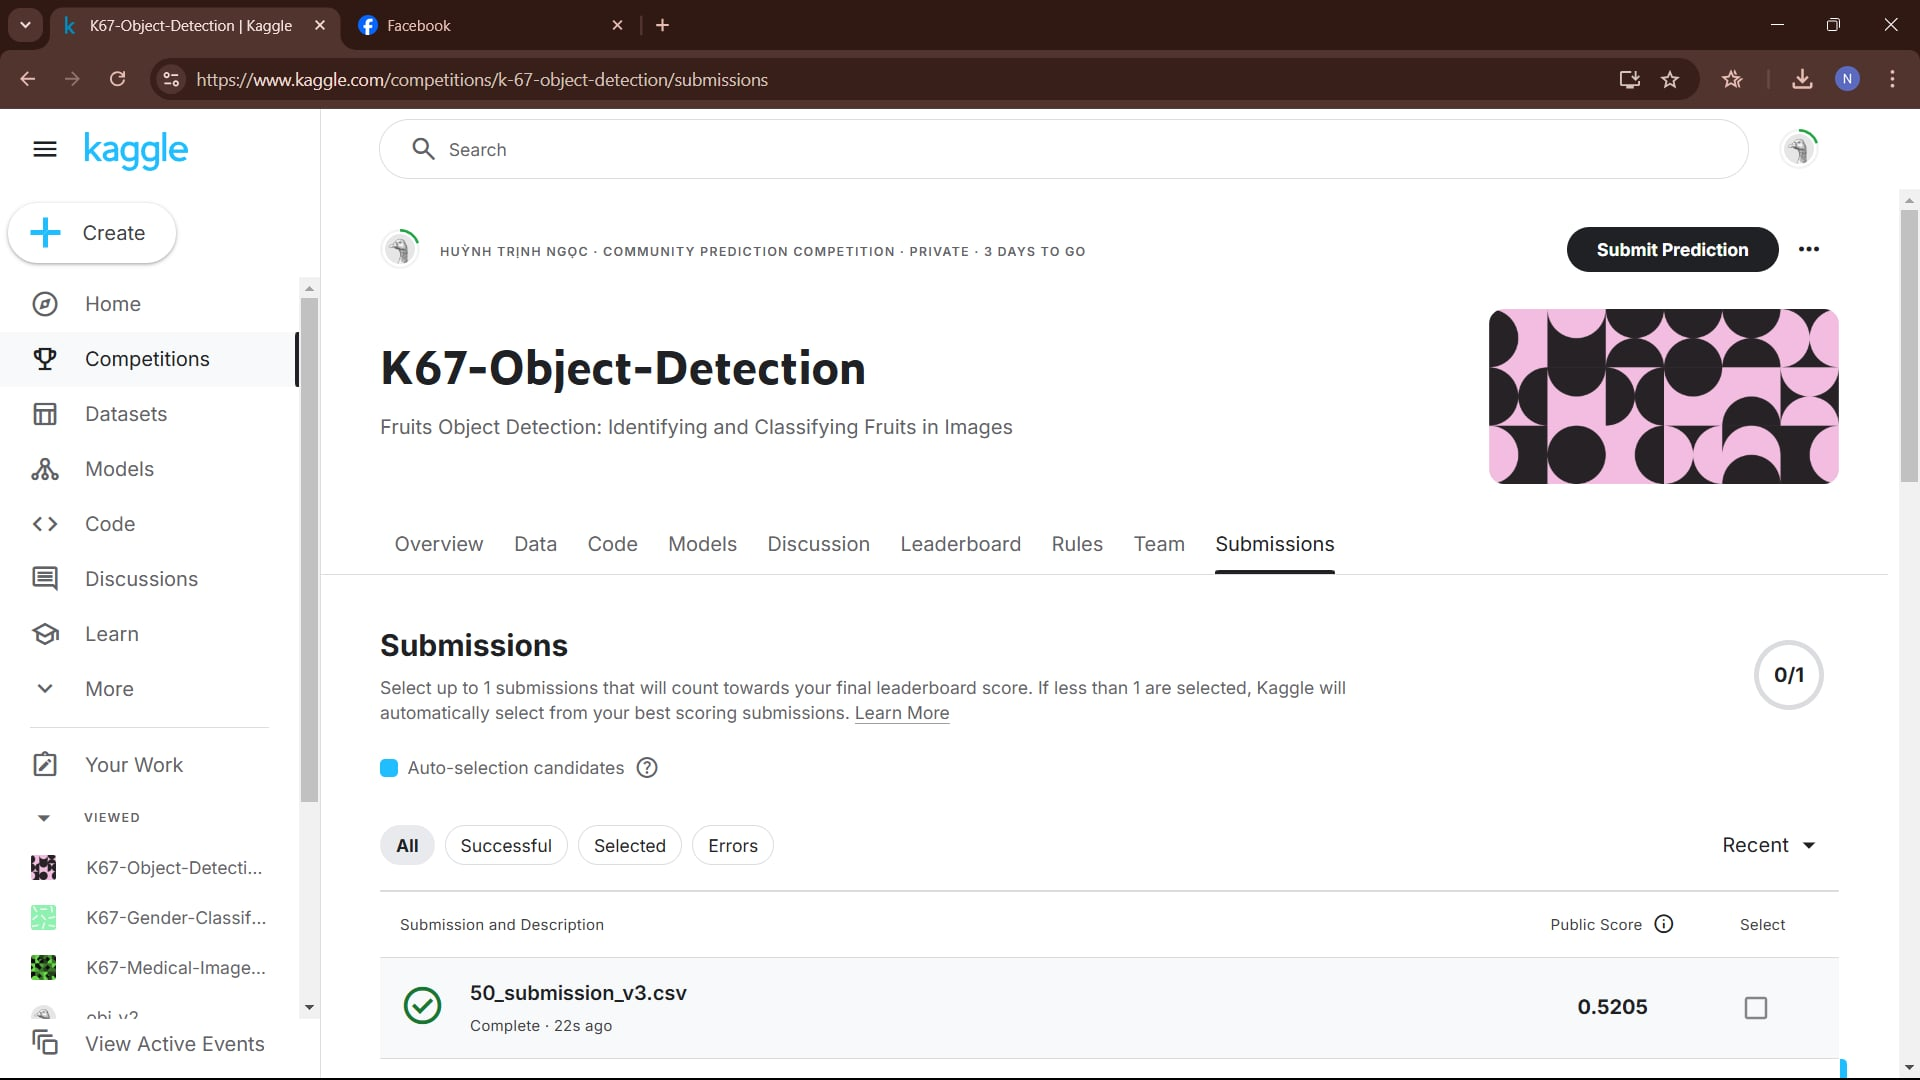
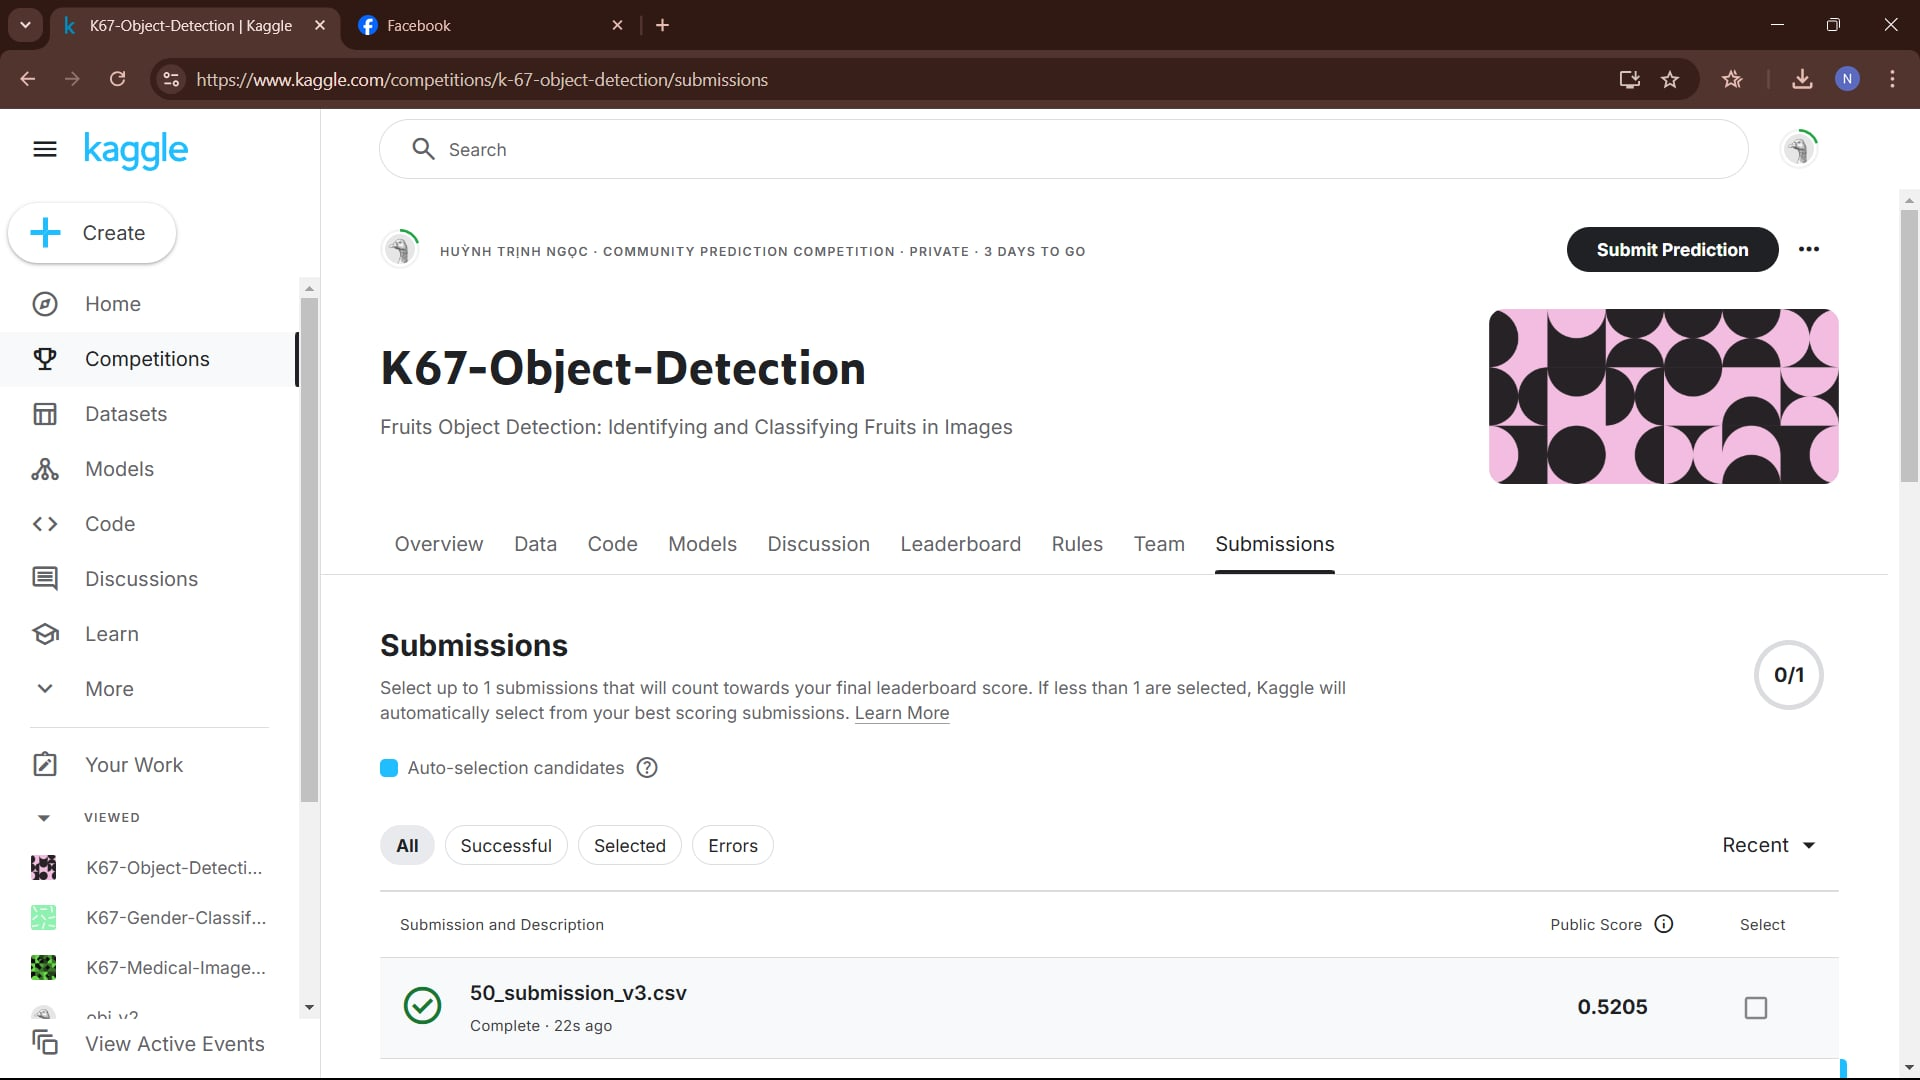

## FasterRCNN pretrain (mAP in 40% test Leaderboard: huynt119 - 0.6074)

**Sử dụng FasterRCNN đã được pretrained trên tập CoCo. Ở đây điều chỉnh layer predict với số class của tập dữ liệu trong competition**

In [12]:
num_classes = 6 + 1

model = fasterrcnn_resnet50_fpn_v2(weights=FasterRCNN_ResNet50_FPN_V2_Weights.DEFAULT)

in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

model = torch.nn.DataParallel(model, device_ids = [0, 1])
model.to(device)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_v2_coco-dd69338a.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_v2_coco-dd69338a.pth
100%|██████████| 167M/167M [00:03<00:00, 52.5MB/s] 


DataParallel(
  (module): FasterRCNN(
    (transform): GeneralizedRCNNTransform(
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        Resize(min_size=(800,), max_size=1333, mode='bilinear')
    )
    (backbone): BackboneWithFPN(
      (body): IntermediateLayerGetter(
        (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (layer1): Sequential(
          (0): Bottleneck(
            (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn2): BatchNorm2d(64, eps=1e-05, mo

**Finetune bằng SGD với learning rate 0.001 và 20 epochs**

In [13]:
learning_rate = 0.001
num_epochs = 20
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=learning_rate, momentum=0.9, weight_decay=0.0005)

In [14]:
train_loader = DataLoader(all_trainset, batch_size=16, shuffle=True, num_workers=4, collate_fn=collate_fn, pin_memory=True)
test_loader = DataLoader(testset, batch_size=16, shuffle=False, num_workers=4, collate_fn=collate_fn_test, pin_memory=True)

In [15]:
train(model, optimizer, train_loader, device, num_epochs, scheduler=None)

  0%|          | 0/20 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
  5%|▌         | 1/20 [19:45<6:15:18, 1185.18s/it]

Epoch [1/20], Loss: 0.4437


 10%|█         | 2/20 [39:43<5:57:51, 1192.88s/it]

Epoch [2/20], Loss: 0.3004


 15%|█▌        | 3/20 [59:42<5:38:48, 1195.82s/it]

Epoch [3/20], Loss: 0.2771


 20%|██        | 4/20 [1:19:40<5:19:08, 1196.76s/it]

Epoch [4/20], Loss: 0.2483


 25%|██▌       | 5/20 [1:39:40<4:59:23, 1197.60s/it]

Epoch [5/20], Loss: 0.2297


 30%|███       | 6/20 [1:59:38<4:39:31, 1197.99s/it]

Epoch [6/20], Loss: 0.2173


 35%|███▌      | 7/20 [2:19:38<4:19:40, 1198.50s/it]

Epoch [7/20], Loss: 0.2064


 40%|████      | 8/20 [2:39:35<3:59:37, 1198.12s/it]

Epoch [8/20], Loss: 0.1930


 45%|████▌     | 9/20 [2:59:33<3:39:39, 1198.10s/it]

Epoch [9/20], Loss: 0.1826


 50%|█████     | 10/20 [3:19:31<3:19:38, 1197.87s/it]

Epoch [10/20], Loss: 0.1698


 55%|█████▌    | 11/20 [3:39:28<2:59:39, 1197.68s/it]

Epoch [11/20], Loss: 0.1610


 60%|██████    | 12/20 [3:59:27<2:39:45, 1198.13s/it]

Epoch [12/20], Loss: 0.1546


 65%|██████▌   | 13/20 [4:19:25<2:19:46, 1198.11s/it]

Epoch [13/20], Loss: 0.1488


 70%|███████   | 14/20 [4:39:24<1:59:50, 1198.37s/it]

Epoch [14/20], Loss: 0.1424


 75%|███████▌  | 15/20 [4:59:22<1:39:51, 1198.39s/it]

Epoch [15/20], Loss: 0.1329


 80%|████████  | 16/20 [5:19:20<1:19:53, 1198.26s/it]

Epoch [16/20], Loss: 0.1283


 85%|████████▌ | 17/20 [5:39:18<59:54, 1198.13s/it]  

Epoch [17/20], Loss: 0.1236


 90%|█████████ | 18/20 [5:59:17<39:56, 1198.32s/it]

Epoch [18/20], Loss: 0.1182


 95%|█████████▌| 19/20 [6:19:15<19:58, 1198.19s/it]

Epoch [19/20], Loss: 0.1136


100%|██████████| 20/20 [6:39:13<00:00, 1197.66s/it]

Epoch [20/20], Loss: 0.1073


In [16]:
torch.save(model.state_dict(), '/kaggle/working/20_model_weights_v2.pth')

**Inference và lưu kết quả**

In [17]:
result_df = pd.DataFrame(columns=["image_id", "bounding_boxes"])

In [18]:
model.eval()

DataParallel(
  (module): FasterRCNN(
    (transform): GeneralizedRCNNTransform(
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        Resize(min_size=(800,), max_size=1333, mode='bilinear')
    )
    (backbone): BackboneWithFPN(
      (body): IntermediateLayerGetter(
        (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (layer1): Sequential(
          (0): Bottleneck(
            (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn2): BatchNorm2d(64, eps=1e-05, mo

In [19]:
test_dir = testset.image_dir
transform_test = transforms.Compose([
    transforms.ToTensor()
])

for img_name in testset.images_names:
    test_img_dir = os.path.join(test_dir, img_name)
    test_image = Image.open(test_img_dir).convert("RGB")
    test_image = transform_test(test_image)
    images = [test_image]  
    images = torch.stack([img.to(device) for img in images], dim=0)

    with torch.no_grad():
        outputs = model(images)

    for output in outputs:
        bboxes = output['boxes'].tolist()
        labels = output['labels'].tolist()
        scores = output['scores'].tolist()
        
        formatted_bboxes = [
            {
                "x_min": bbox[0],
                "y_min": bbox[1],
                "x_max": bbox[2],
                "y_max": bbox[3],
                "class": label - 1,
                "confidence": score
            }
            for bbox, label, score in zip(bboxes, labels, scores)
        ]

        bboxes_str = str(formatted_bboxes).replace("'", '"')

        tmp_df = pd.DataFrame({
            "image_id": [img_name.replace(".jpg", "")], 
            "bounding_boxes": [bboxes_str]  
        })

        result_df = pd.concat([result_df, tmp_df], ignore_index = True)
display(result_df)

,image_id,bounding_boxes
0,4b8598bbe9e5a886_jpg.rf.50942ee420468efa8e178d...,"[{""x_min"": 0.752227783203125, ""y_min"": 376.532..."
1,b2c6d6f79385eebf_jpg.rf.56e59671d857e2c5b66645...,"[{""x_min"": 58.1674690246582, ""y_min"": 535.2075..."
2,006ac0b3d61f1ee9_jpg.rf.b59fe5afdaf4b158ae7df6...,"[{""x_min"": 115.18718719482422, ""y_min"": 223.33..."
3,3d0afd5cc88a30ae_jpg.rf.c1399898b014001d2e4225...,"[{""x_min"": 283.765869140625, ""y_min"": 156.5874..."
4,271ec9c6a961fd4d_jpg.rf.8d460c22831b8c54cf8746...,"[{""x_min"": 194.57798767089844, ""y_min"": 4.7206..."
...,...,...
843,f4a6b05f8150a4b1_jpg.rf.e398cd6b317b7e9387b57f...,"[{""x_min"": 135.9303741455078, ""y_min"": 80.6729..."
844,7bee144c7ed1d436_jpg.rf.f9b690c822aee308b9387a...,"[{""x_min"": 366.0017395019531, ""y_min"": 126.557..."
845,3571ba354fa3c699_jpg.rf.c209c62aea68a9a2d291c3...,"[{""x_min"": 0.0, ""y_min"": 0.0, ""x_max"": 589.817..."
846,03e00e57108e0901_jpg.rf.d07ccd62a001bf31bf6cb7...,"[{""x_min"": 187.48162841796875, ""y_min"": 204.25..."


In [20]:
result_df.to_csv('/kaggle/working/20_submission_v2.csv', index=False)

**mAP hiển thị trên 40% test leaderboard là 0.6074. Đây là model tốt nhất đã nộp**

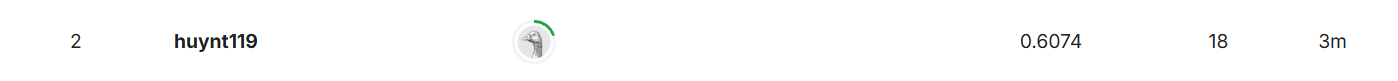

# Kết luận

**Do việc thu nhỏ mô hình (chỉ lấy 3 layer feature maps, giảm số chiều trung gian) và huấn luyện trên tập dữ liệu khá nhỏ nên hiệu suất của mô hình custom sẽ không thể bằng mô hình gốc đã được pretrained trên tập dữ liệu lớn. Điều này cho thấy sức mạnh của các mô hình pretrained.**